In [1]:
import numpy as np
import pandas as pd
import pickle
#import pickle5
import csv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import collections
import os

In [5]:
STIMULUS = "black" # 21st_year, slumlordreach
MODEL = 'bert-base-uncased' # bert-base-uncased, gpt2
p='inf' # 1, 2, inf
file_type = 'npy' #npy, csv, pkl
look_back = 20 # 20, 120
version = 2 # version number for debugging; the current version is 2
attn_dir = 'concat' # bidir, fwd, bck, concat

In [6]:
'''
#Load syntactiv complexity data
if file_type == 'csv':
    assert STIMULUS == '21st_year' and version == 0
    with open(f'data/{STIMULUS}/{MODEL}/syntactic_analyses/old_data/{STIMULUS}_{MODEL}_syntactic_complexity_L-{p}.csv','r') as f:
        reader = csv.reader(f)
        vec_file = [row for row in reader]
        vec_head = vec_file[0]
        vec_text = vec_file[1:]
    vecs  = [[float(element) for element in row[vec_head.index(f'attention_heads_L{p}_vector')][1:-1].split(', ')] \
             if row[vec_head.index(f'attention_heads_L{p}_vector')] != '' else [] for row in vec_text]
    vec_ids = np.array([len(vec)==144 for vec in vecs])
    print(vec_ids)
    print(np.sum(vec_ids==1))
    print(np.sum(vec_ids==0))   
elif file_type == 'npy':
    if STIMULUS == '21st_year' and version == 0:
        vecs = np.load(f'data/{STIMULUS}/{MODEL}/syntactic_analyses/old_data/{STIMULUS}_{MODEL}_syntactic_complexity_L-{p}-T20.npy',allow_pickle=True)
        vec_ids = np.array([all(~np.isnan(vec)) for vec in vecs])
    elif version == 1:
        vecs = np.load(f'data/{STIMULUS}/{MODEL}/syntactic_analyses/{STIMULUS}_{MODEL}_syntactic_complexity_L-{p}_T-{look_back}.npy',allow_pickle=True)
        vec_ids = np.array([vec is not None for vec in vecs])
    elif version == 2:
        vecs = np.load(f'data/{STIMULUS}/{MODEL}/syntactic_analyses/{STIMULUS}_{MODEL}_syntactic_complexity_L-{p}_T-{look_back}_D-{attn_dir}.npy',allow_pickle=True)
        vec_ids = np.array([vec is not None for vec in vecs])
    print(vec_ids)
    print(np.sum(vec_ids==1))
    print(np.sum(vec_ids==0))
elif file_type == 'pkl':
    assert STIMULUS == '21st_year' and version == 0
    with open(f'data/{STIMULUS}/{MODEL}/syntactic_analyses/old_data/{STIMULUS}_{MODEL}_syntactic_complexity_L-{p}.pkl','rb') as f:
        vecs = pickle.load(f)
    vecs = vecs[f'attention_heads_L{p}_vector']
    vec_ids = np.array([vec is not None for vec in vecs])
    print(np.sum(vec_ids==1))
    print(np.sum(vec_ids==0))
else:
    print('No dataset matches your description')
'''

"\n#Load syntactiv complexity data\nif file_type == 'csv':\n    assert STIMULUS == '21st_year' and version == 0\n    with open(f'data/{STIMULUS}/{MODEL}/syntactic_analyses/old_data/{STIMULUS}_{MODEL}_syntactic_complexity_L-{p}.csv','r') as f:\n        reader = csv.reader(f)\n        vec_file = [row for row in reader]\n        vec_head = vec_file[0]\n        vec_text = vec_file[1:]\n    vecs  = [[float(element) for element in row[vec_head.index(f'attention_heads_L{p}_vector')][1:-1].split(', ')]              if row[vec_head.index(f'attention_heads_L{p}_vector')] != '' else [] for row in vec_text]\n    vec_ids = np.array([len(vec)==144 for vec in vecs])\n    print(vec_ids)\n    print(np.sum(vec_ids==1))\n    print(np.sum(vec_ids==0))   \nelif file_type == 'npy':\n    if STIMULUS == '21st_year' and version == 0:\n        vecs = np.load(f'data/{STIMULUS}/{MODEL}/syntactic_analyses/old_data/{STIMULUS}_{MODEL}_syntactic_complexity_L-{p}-T20.npy',allow_pickle=True)\n        vec_ids = np.array

In [7]:
if version < 2:
    assert STIMULUS == '21st_year'
    if file_type == 'csv':
        assert version == 0
        with open(f'data/{STIMULUS}/{MODEL}/syntactic_analyses/old_data/{STIMULUS}_{MODEL}_syntactic_complexity_L-{p}.csv','r') as f:
            reader = csv.reader(f)
            vec_file = [row for row in reader]
            vec_head = vec_file[0]
            vec_text = vec_file[1:]
        vecs  = [[float(element) for element in row[vec_head.index(f'attention_heads_L{p}_vector')][1:-1].split(', ')] \
                 if row[vec_head.index(f'attention_heads_L{p}_vector')] != '' else [] for row in vec_text]
        vec_ids = np.array([len(vec)==144 for vec in vecs]) 
    elif file_type == 'pkl':
        assert version == 0
        with open(f'data/{STIMULUS}/{MODEL}/syntactic_analyses/old_data/{STIMULUS}_{MODEL}_syntactic_complexity_L-{p}.pkl','rb') as f:
            vecs = pickle.load(f)
        vecs = vecs[f'attention_heads_L{p}_vector']
        vec_ids = np.array([vec is not None for vec in vecs])
    if file_type == 'npy':
        if version == 0:
            vecs = np.load(f'data/{STIMULUS}/{MODEL}/syntactic_analyses/old_data/{STIMULUS}_{MODEL}_syntactic_complexity_L-{p}-T20.npy',allow_pickle=True)
            vec_ids = np.array([all(~np.isnan(vec)) for vec in vecs])
        elif version == 1:
            vecs = np.load(f'data/{STIMULUS}/{MODEL}/syntactic_analyses/{STIMULUS}_{MODEL}_syntactic_complexity_L-{p}_T-{look_back}.npy',allow_pickle=True)
            vec_ids = np.array([vec is not None for vec in vecs])    
elif version == 2:
    if attn_dir == 'concat':
        fwd_vecs = np.load(f'data/{STIMULUS}/{MODEL}/syntactic_analyses/{STIMULUS}_{MODEL}_syntactic_complexity_L-{p}_T-{look_back}_D-fwd.npy',allow_pickle=True)
        bck_vecs = np.load(f'data/{STIMULUS}/{MODEL}/syntactic_analyses/{STIMULUS}_{MODEL}_syntactic_complexity_L-{p}_T-{look_back}_D-bck.npy',allow_pickle=True)
        fwd_vec_ids = np.array([vec is not None for vec in fwd_vecs])
        bck_vec_ids = np.array([vec is not None for vec in bck_vecs])
        assert all(fwd_vec_ids==bck_vec_ids)
        vec_ids = fwd_vec_ids
        vecs = [fwd_vec+bck_vec if vec_id else None for fwd_vec,bck_vec,vec_id in zip(fwd_vecs,bck_vecs,vec_ids)]
    else:    
        vecs = np.load(f'data/{STIMULUS}/{MODEL}/syntactic_analyses/{STIMULUS}_{MODEL}_syntactic_complexity_L-{p}_T-{look_back}_D-{attn_dir}.npy',allow_pickle=True)
        vec_ids = np.array([vec is not None for vec in vecs])
print(vec_ids)
print(np.sum(vec_ids==1))
print(np.sum(vec_ids==0))   

[False False False False False False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [8]:
#Load linguistic features
with open(f'data/{STIMULUS}/tr_tokens_new.csv','r') as f:
    reader = csv.reader(f)
    ling_file = [row for row in reader]
    ling_head = ling_file[0]
    ling_text = ling_file[1:]
features = [[element[1:-1] for element in row[ling_head.index('dep_rel')][1:-1].split(', ')]\
           if len(row[ling_head.index('dep_rel')]) >0 else [] for row in ling_text]
feature_ids = np.array([feature[0] != '' for feature in features])
print(feature_ids)
print(np.sum(feature_ids==1))
print(np.sum(feature_ids==0))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True False
 False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False False False
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True Fa

In [9]:
#Choose TRs that both have syntactic complexity and linguistic features
assert len(vec_ids) == len(feature_ids)
ids = np.array([vec_id and feature_id for vec_id, feature_id in zip(vec_ids,feature_ids)])
print(np.sum(ids==1))

474


In [10]:
new_vecs = np.array([vec for element,vec in zip(ids,vecs) if element])
new_features = [feature for element,feature in zip(ids,features) if element]
assert new_vecs.shape[0] == len(new_features)
print(new_vecs.shape)

(474, 288)


In [11]:
'''
print(csv_old.shape,npy_old.shape,npy_new.shape)
plt.imshow((csv_old!=npy_old).astype(np.int))
plt.colorbar()
plt.show()
plt.imshow((npy_old!=npy_new).astype(np.int))
plt.colorbar()
plt.show()
plt.imshow(np.divide(np.sum(csv_old*npy_old,axis=0),np.linalg.norm(csv_old,axis=0)*np.linalg.norm(npy_old,axis=0)).reshape(12,12))
plt.colorbar()
plt.show()
plt.imshow(np.divide(np.sum(npy_old*npy_new,axis=0),np.linalg.norm(npy_old,axis=0)*np.linalg.norm(npy_new,axis=0)).reshape(12,12))
plt.colorbar()
plt.show()
'''

'\nprint(csv_old.shape,npy_old.shape,npy_new.shape)\nplt.imshow((csv_old!=npy_old).astype(np.int))\nplt.colorbar()\nplt.show()\nplt.imshow((npy_old!=npy_new).astype(np.int))\nplt.colorbar()\nplt.show()\nplt.imshow(np.divide(np.sum(csv_old*npy_old,axis=0),np.linalg.norm(csv_old,axis=0)*np.linalg.norm(npy_old,axis=0)).reshape(12,12))\nplt.colorbar()\nplt.show()\nplt.imshow(np.divide(np.sum(npy_old*npy_new,axis=0),np.linalg.norm(npy_old,axis=0)*np.linalg.norm(npy_new,axis=0)).reshape(12,12))\nplt.colorbar()\nplt.show()\n'

In [12]:
def CreateLabels(new_features,label):
    return np.array([1 if label in feature else 0 for feature in new_features])
def MyCrossValidation(X,y,model,verbose,split_num):
    assert X.shape[0] == y.shape[0], 'Shape mismatch between X and y; make sure both are np arrays'
    random_ids = np.random.permutation(X.shape[0])
    batch_size = X.shape[0] // split_num
    scores = []
    params= []
    for i in range(split_num):
        if i == split_num-1:
            test_ids = random_ids[batch_size*i:]
        else:
            test_ids = random_ids[batch_size*i:batch_size*(i+1)]
        train_ids = np.array([element for element in random_ids if element not in test_ids])
        assert len(test_ids) +  len(train_ids) == X.shape[0]
        train_X = X[train_ids]
        test_X = X[test_ids]
        train_y = y[train_ids]
        test_y = y[test_ids]
        model.fit(train_X,train_y)
        scores.append(model.score(test_X,test_y))
        assert scores[-1] == np.mean(model.predict(test_X)==test_y)
        params.append(model.coef_[0])
        plt.plot(model.coef_[0])
        if verbose:
            print([ConvertHeadNotation(head_num) for head_num in params[-1].argsort()[::-1][:5]])
    plt.show()
    return scores,np.array(params)
def ConvertHeadNotation(head_num,attn_dir):
    if attn_dir == 'concat':
        head_num = head_num%144
    return f'{head_num//12+1}-{head_num%12+1}'

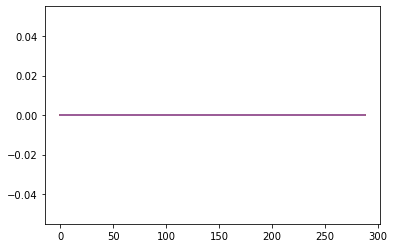

Head for prep　for alpha = 0.01: 1-1 for 5/5 splits


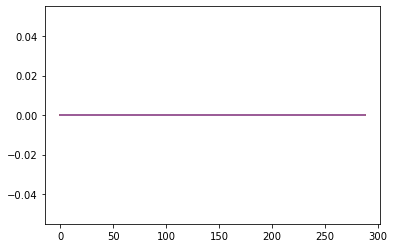

Head for pobj　for alpha = 0.01: 1-1 for 5/5 splits


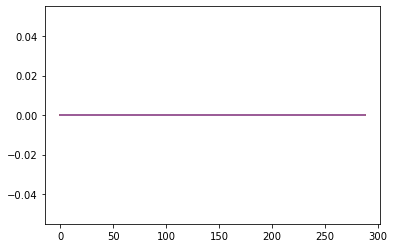

Head for det　for alpha = 0.01: 1-1 for 5/5 splits


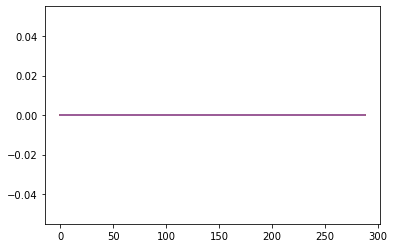

Head for nsubj　for alpha = 0.01: 1-1 for 5/5 splits


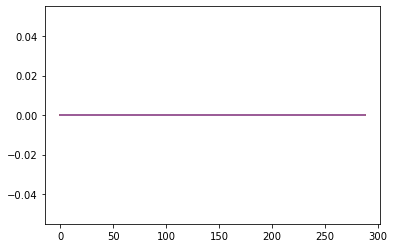

Head for amod　for alpha = 0.01: 1-1 for 5/5 splits


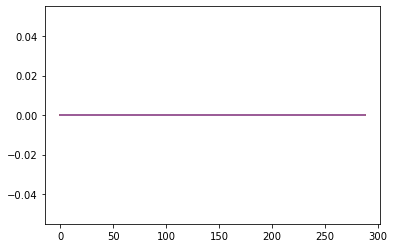

Head for dobj　for alpha = 0.01: 1-1 for 5/5 splits


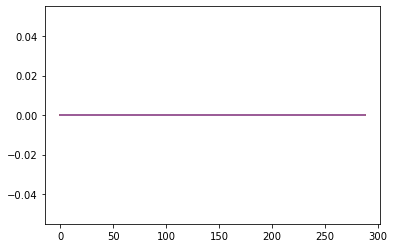

Head for advmod　for alpha = 0.01: 1-1 for 5/5 splits


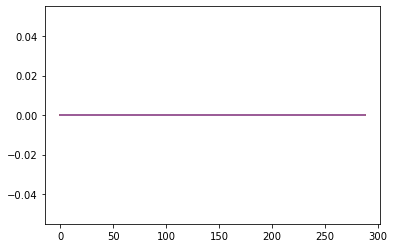

Head for aux　for alpha = 0.01: 1-1 for 5/5 splits


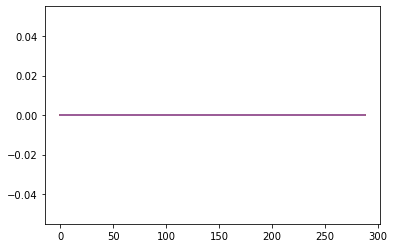

Head for poss　for alpha = 0.01: 1-1 for 5/5 splits


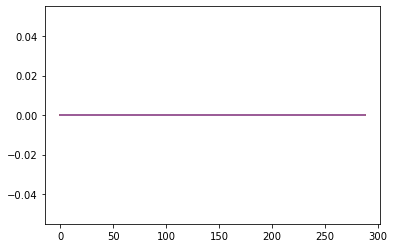

Head for ccomp　for alpha = 0.01: 1-1 for 5/5 splits


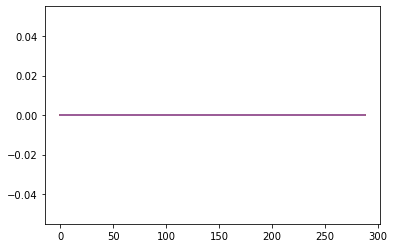

Head for mark　for alpha = 0.01: 1-1 for 5/5 splits


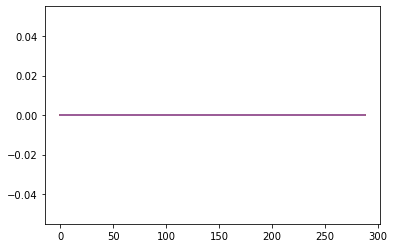

Head for prt　for alpha = 0.01: 1-1 for 5/5 splits


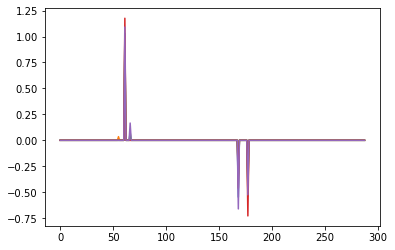

Head for prep　for alpha = 0.1: 6-2 for 5/5 splits


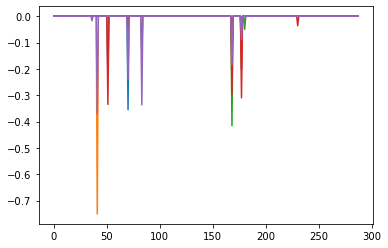

Head for pobj　for alpha = 0.1: 1-1 for 5/5 splits


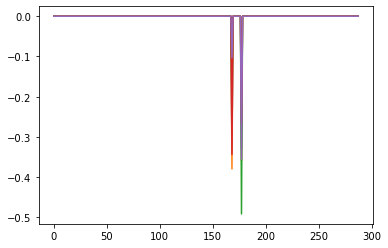

Head for det　for alpha = 0.1: 1-1 for 5/5 splits


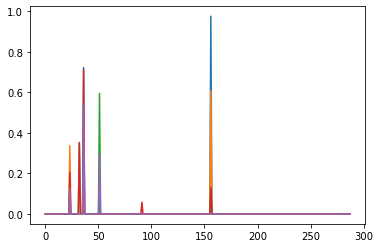

Head for nsubj　for alpha = 0.1: 2-1 for 2/5 splits


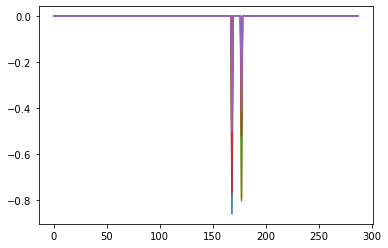

Head for amod　for alpha = 0.1: 1-1 for 5/5 splits


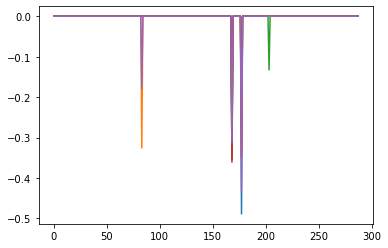

Head for dobj　for alpha = 0.1: 1-1 for 5/5 splits


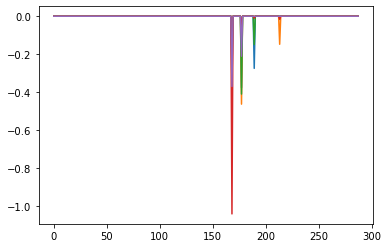

Head for advmod　for alpha = 0.1: 1-1 for 5/5 splits


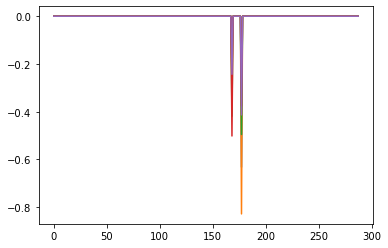

Head for aux　for alpha = 0.1: 1-1 for 5/5 splits


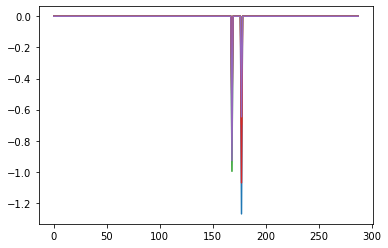

Head for poss　for alpha = 0.1: 1-1 for 5/5 splits


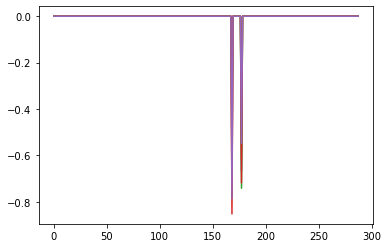

Head for ccomp　for alpha = 0.1: 1-1 for 5/5 splits


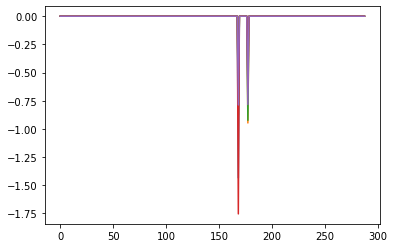

Head for mark　for alpha = 0.1: 1-1 for 5/5 splits


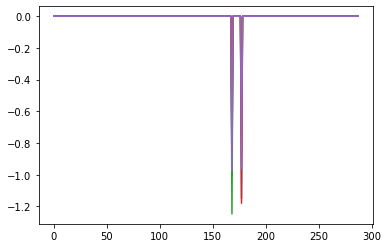

Head for prt　for alpha = 0.1: 1-1 for 5/5 splits


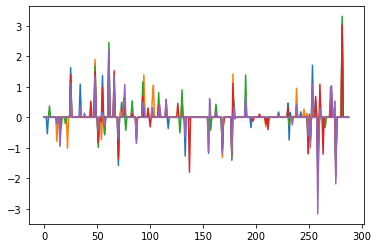

Head for prep　for alpha = 1: 12-6 for 4/5 splits


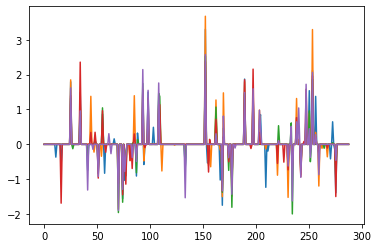

Head for pobj　for alpha = 1: 1-9 for 5/5 splits


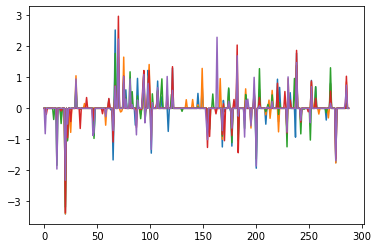

Head for det　for alpha = 1: 6-8 for 2/5 splits


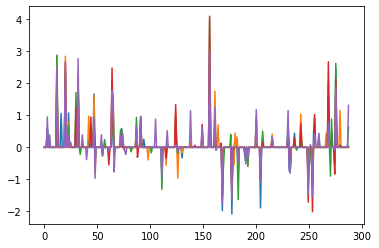

Head for nsubj　for alpha = 1: 2-1 for 4/5 splits


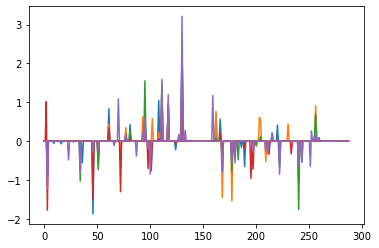

Head for amod　for alpha = 1: 11-11 for 5/5 splits


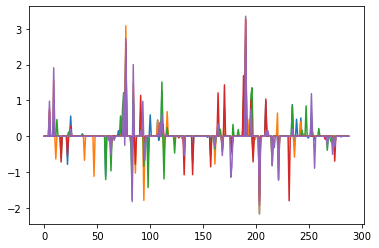

Head for dobj　for alpha = 1: 4-11 for 5/5 splits


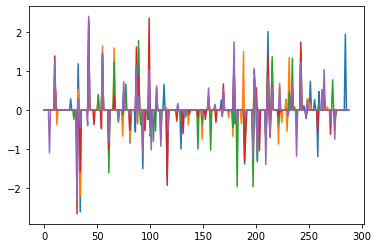

Head for advmod　for alpha = 1: 4-7 for 2/5 splits


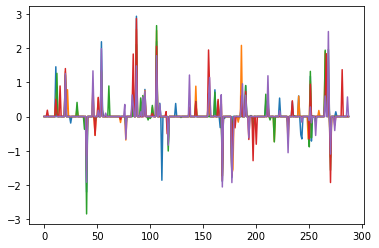

Head for aux　for alpha = 1: 8-4 for 3/5 splits


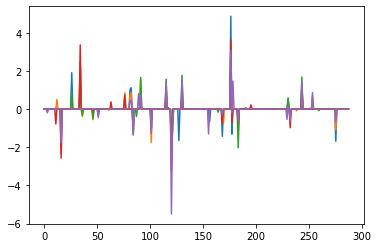

Head for poss　for alpha = 1: 3-9 for 4/5 splits


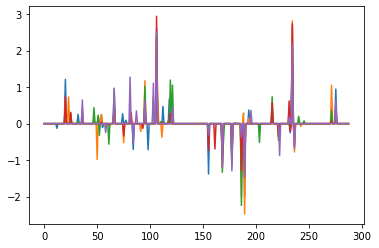

Head for ccomp　for alpha = 1: 9-11 for 3/5 splits


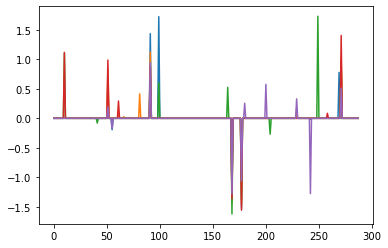

Head for mark　for alpha = 1: 8-8 for 2/5 splits


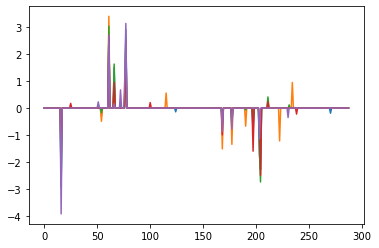

Head for prt　for alpha = 1: 6-2 for 3/5 splits


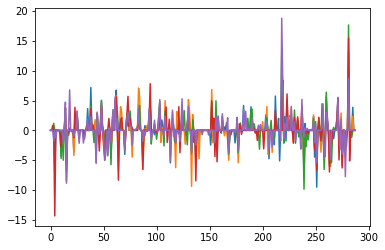

Head for prep　for alpha = 10: 12-6 for 3/5 splits


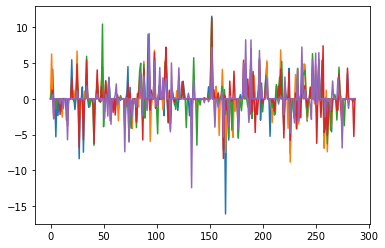

Head for pobj　for alpha = 10: 1-9 for 4/5 splits


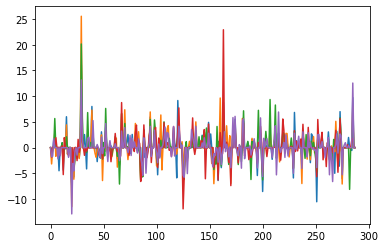

Head for det　for alpha = 10: 3-6 for 4/5 splits


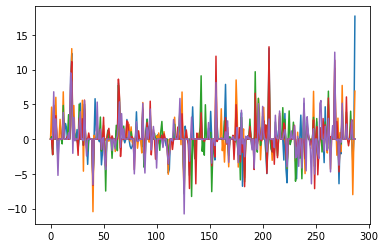

Head for nsubj　for alpha = 10: 6-3 for 2/5 splits


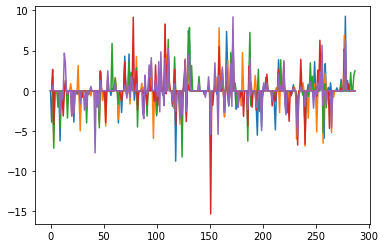

Head for amod　for alpha = 10: 12-3 for 1/5 splits


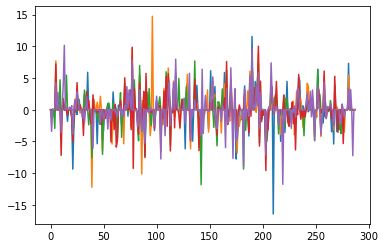

Head for dobj　for alpha = 10: 4-11 for 2/5 splits


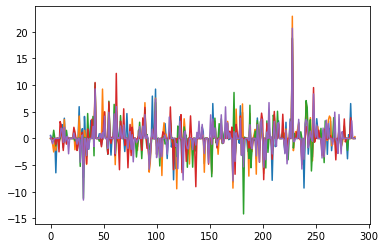

Head for advmod　for alpha = 10: 8-1 for 4/5 splits


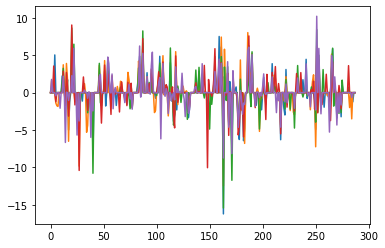

Head for aux　for alpha = 10: 2-9 for 2/5 splits


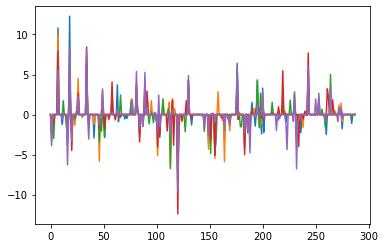

Head for poss　for alpha = 10: 2-7 for 2/5 splits


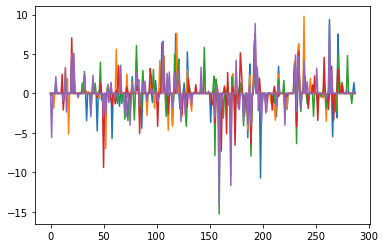

Head for ccomp　for alpha = 10: 5-2 for 2/5 splits


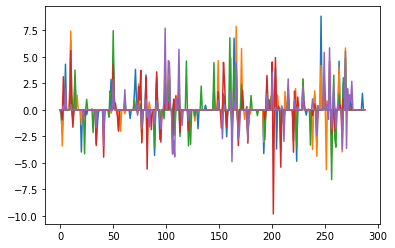

Head for mark　for alpha = 10: 9-7 for 1/5 splits


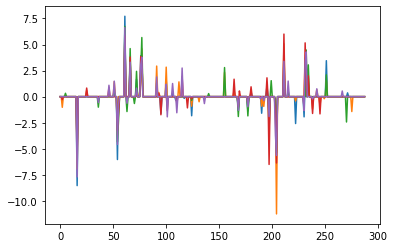

Head for prt　for alpha = 10: 6-2 for 4/5 splits


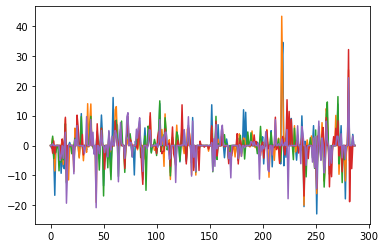

Head for prep　for alpha = 100: 12-6 for 3/5 splits


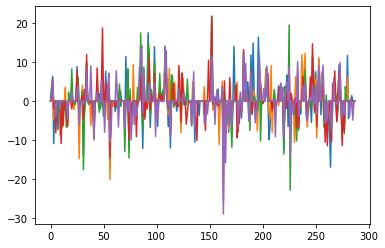

Head for pobj　for alpha = 100: 1-9 for 4/5 splits


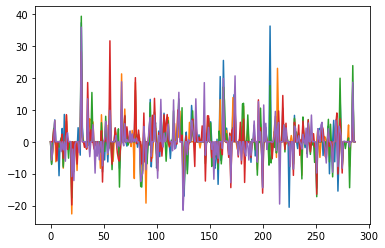

Head for det　for alpha = 100: 3-6 for 3/5 splits


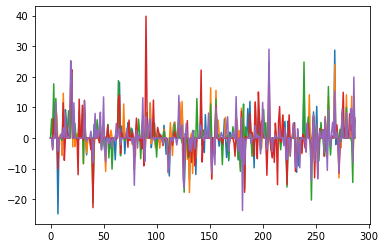

Head for nsubj　for alpha = 100: 11-5 for 2/5 splits


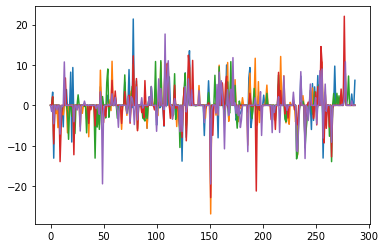

Head for amod　for alpha = 100: 7-7 for 1/5 splits


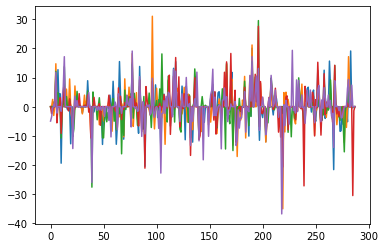

Head for dobj　for alpha = 100: 5-5 for 2/5 splits


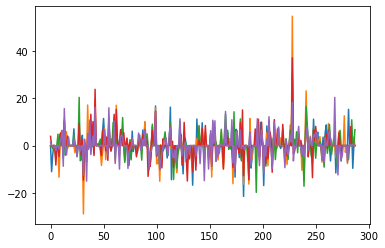

Head for advmod　for alpha = 100: 8-1 for 4/5 splits


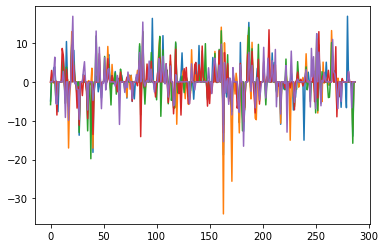

Head for aux　for alpha = 100: 12-5 for 1/5 splits


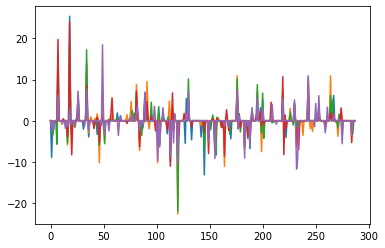

Head for poss　for alpha = 100: 2-7 for 3/5 splits


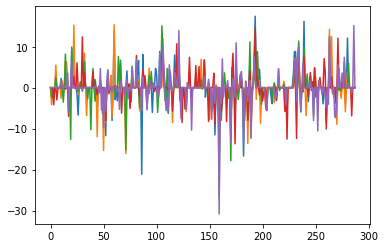

Head for ccomp　for alpha = 100: 5-2 for 2/5 splits


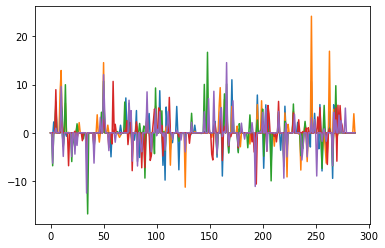

Head for mark　for alpha = 100: 3-4 for 1/5 splits


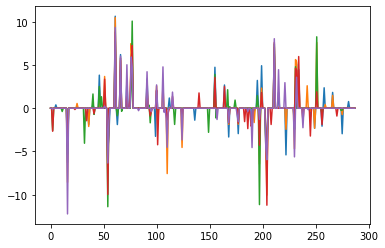

Head for prt　for alpha = 100: 6-2 for 4/5 splits


In [13]:
out_list = []
out_head = ['alpha','dep_rel','max_head','score','max_head for each split in CV','confidence']
split_num=5
verbose = False
dep_rels = ['prep','pobj','det','nsubj','amod','dobj','advmod','aux','poss','ccomp','mark','prt']
alphas = [0.01,0.1,1,10,100]
score_array = np.zeros((len(alphas),len(dep_rels),split_num))
for alpha_id, alpha in enumerate(alphas):
    #Smaller alpha for stronger regularization
    for dep_rel_id, dep_rel in enumerate(dep_rels):
        labels = CreateLabels(new_features,dep_rel)
        model = LogisticRegression(penalty='l1', solver='liblinear',C=alpha)
        scores,params = MyCrossValidation(new_vecs,labels,model,verbose,split_num)
        important_head = collections.Counter([param.argmax() for param in params]).most_common()[0]
        print(f'Head for {dep_rel}　for alpha = {alpha}: {ConvertHeadNotation(important_head[0],attn_dir)} for {important_head[1]}/5 splits')
        out_list.append([alpha,dep_rel,ConvertHeadNotation(important_head[0],attn_dir), np.mean(scores),\
                          ', '.join([ConvertHeadNotation(param.argmax(),attn_dir) for param in params]),important_head[1]/5])
        score_array[alpha_id,dep_rel_id,:] = scores
pd.DataFrame(out_list,columns=out_head).to_csv(f'DepRelDecoding_{STIMULUS}_{MODEL}_L-{p}_T-{look_back}_D-{attn_dir}.csv')

In [14]:
with open(f'DepRelDecoding_{STIMULUS}_{MODEL}_L-{p}_T-{look_back}_D-{attn_dir}.csv','r') as f:
    reader = csv.reader(f)
    file = [row for row in reader]
    head = file[0]
    text = file[1:]

out_list_new = []
new_head = ['dep_rel','score','max_head','confidence','alpha']
score_array_new = np.zeros((len(dep_rels),split_num))
for dep_rel_id, dep_rel in enumerate(dep_rels):
    performance = [[float(row[head.index('score')]),row[head.index('max_head')],row[head.index('confidence')],row[head.index('alpha')]] for row in text if row[head.index('dep_rel')]==dep_rel]
    max_id = np.argmax(np.array([row[0] for row in performance]))
    out_list_new.append([dep_rel]+performance[max_id])
    score_array_new[dep_rel_id,:] = score_array[max_id,dep_rel_id,:]
    assert np.mean(score_array_new[dep_rel_id]) == performance[max_id][0]
pd.DataFrame(out_list_new,columns=new_head).to_csv(f'DepRelDecoding_{STIMULUS}_{MODEL}_L-{p}_T-{look_back}_D-{attn_dir}_new.csv')

In [15]:
score_dict = {}
for dep_rel,score_list in zip(dep_rels,score_array_new):
    score_dict[dep_rel] = score_list
with open(f'decoding_scores_{STIMULUS}_{MODEL}_L-{p}_T-{look_back}_D-{attn_dir}.pkl','wb') as f:
    pickle.dump(score_dict,f)

In [16]:
score_dict

{'prep': array([0.77659574, 0.82978723, 0.86170213, 0.80851064, 0.83673469]),
 'pobj': array([0.77659574, 0.81914894, 0.79787234, 0.84042553, 0.82653061]),
 'det': array([0.77659574, 0.79787234, 0.73404255, 0.77659574, 0.70408163]),
 'nsubj': array([0.88297872, 0.78723404, 0.77659574, 0.86170213, 0.82653061]),
 'amod': array([0.91489362, 0.86170213, 0.9787234 , 0.92553191, 0.90816327]),
 'dobj': array([0.85106383, 0.78723404, 0.82978723, 0.77659574, 0.80612245]),
 'advmod': array([0.79787234, 0.78723404, 0.82978723, 0.72340426, 0.80612245]),
 'aux': array([0.80851064, 0.84042553, 0.81914894, 0.82978723, 0.8877551 ]),
 'poss': array([0.94680851, 0.95744681, 0.92553191, 0.92553191, 0.93877551]),
 'ccomp': array([0.88297872, 0.92553191, 0.90425532, 0.92553191, 0.90816327]),
 'mark': array([0.95744681, 0.95744681, 0.94680851, 0.9893617 , 0.95918367]),
 'prt': array([0.9787234 , 0.95744681, 1.        , 0.96808511, 0.95918367])}

In [18]:
STIMULUS = 'black'
MODEL = 'bert-base-uncased'
p = 'inf'
look_back = 20
split_num = 5
attn_dir_list = ['bidir','fwd','bck','concat']
dep_rels = ['prep','pobj','det','nsubj','amod','dobj','advmod','aux','poss','ccomp','mark','prt']
plot_data = np.zeros((len(attn_dir_list),len(dep_rels),split_num))
for attn_dir_id,attn_dir in enumerate(attn_dir_list):
    with open(f'DecodingResults/decoding_scores_{STIMULUS}_{MODEL}_L-{p}_T-{look_back}_D-{attn_dir}.pkl','rb') as f:
        score_dict = pickle.load(f)
        for dep_rel_id,dep_rel in enumerate(dep_rels):
            plot_data[attn_dir_id,dep_rel_id,:] = score_dict[dep_rel]

FileNotFoundError: [Errno 2] No such file or directory: 'DecodingResults/decoding_scores_black_bert-base-uncased_L-inf_T-20_D-bidir.pkl'

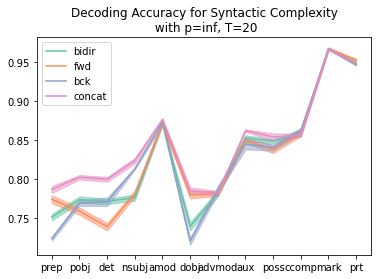

In [22]:
import seaborn as sns
color_list = sns.color_palette('Set2')
for attn_dir_id,attn_dir,plot_data_attn_dir in zip(np.arange(len(attn_dir)),attn_dir_list,plot_data):
    plt.plot(plot_data_attn_dir.mean(axis=-1),label=attn_dir,color=color_list[attn_dir_id])
    plt.fill_between(np.arange(plot_data_attn_dir.shape[0]),\
                     plot_data_attn_dir.mean(axis=-1)-plot_data_attn_dir.std(axis=-1)/plot_data_attn_dir.shape[-1],\
                     plot_data_attn_dir.mean(axis=-1)+plot_data_attn_dir.std(axis=-1)/plot_data_attn_dir.shape[-1],\
                     color = color_list[attn_dir_id],alpha=0.5)
plt.legend()
plt.xticks(np.arange(plot_data.shape[1]),dep_rels)
plt.title(f'Decoding Accuracy for Syntactic Complexity\n with p={p}, T={look_back}')
plt.show()